Import libraries

In [2]:
import torch
import tiktoken
from torch.utils.data import Dataset, DataLoader
from coding_gpt2_to_predict_next_token import GPTModel, generate_text_simple


Importing file

In [ ]:
with open("../Required_files/the-verdict.txt",'r',encoding = "utf-8") as file:
    text_data = file.read()


print(text_data[:99])
print(text_data[-99:])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 
it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


Check number of tokens

In [4]:
tokenizer = tiktoken.get_encoding("gpt2")
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


Training/Validation ratio

In [5]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

Decide GPT Confriguration

In [6]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMPLEMENTING A DATA LOADER
1) Implement a class named GPTDatasetV1 which uses dataset utility of pytorch ,tokenizes and   segments  the dataset to generate input–output target pairs.

2) Define a function create_dataloader_v1 that leverages the GPTDatasetV1 class along with PyTorch’s DataLoader utility to build the dataloader needed for training an LLM.

GPTDatasetV1 class

Step 1: Tokenize the entire text
    
Step 2: Use a sliding window to chunk the book into overlapping sequences of max_length

Step 3: Return the total number of rows in the dataset

Step 4: Return a single row from the dataset

In [7]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

Define create_dataloader_v1 function

Step 1: Initialize the tokenizer

Step 2: Create dataset

Step 3: drop_last=True drops the last batch if it is shorter than the specified batch_size to prevent loss spikes
during training

Step 4: The number of CPU processes to use for preprocessing

In [8]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    
    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

Create Dataloader for current dataset

1) Batch your data automatically

   Instead of feeding one sample at a time, it groups data into batches (e.g., 32 samples per batch), which speeds up training and improves GPU utilization.

2) Shuffle data

   Randomizes the order of samples each epoch to help the model generalize better and avoid learning data order patterns.

3) Load data in parallel (multi-threading)

   Uses multiple worker threads to load data while the GPU is training on the previous batch — preventing the GPU from sitting idle.

In [9]:
torch.manual_seed(123)



train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

Sanity checks

In [10]:
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [11]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [12]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


Calculation of cross entropy loss function using pytorch

In [13]:
def calc_loss_batch(input_batch, target_batch, model ,device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches = None):
    total_loss = 0
    if(len(data_loader) == 0):
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i <= num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()    
        else:
            break
    return total_loss / num_batches

Model Training

Step 1: Initialize lists to track losses and tokens seen

Step 2: Start the main training loop

Step 3: Reset loss gradients from previous batch iteration

Step 4: Calculate loss gradients

Step 5: Update model weights using loss gradients

Step 6: Optional evaluation step

Step 7: Print a sample text after each epoch

Utility functions for training

In [14]:
def evaluate_model(model ,train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, eval_iter)
    model.train()
    return train_loss, val_loss

In [15]:
def text_to_token_ids (text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size =  model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    model.train()
    with torch.no_grad():
        token_ids = generate_text_simple(
            model, idx =encoded,
            max_new_tokens =50, context_size = context_size 
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format

Model training function

In [16]:
def train_model_simple(model, train_loader, val_loader, optimizer,device,num_epochs, 
                       eval_freq,eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train() # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device) # Calculate loss for current batch
            loss.backward() # Backpropagate to compute gradients
            optimizer.step()    # Update model parameters based on computed gradients
            tokens_seen += input_batch.numel() # Update total tokens seen
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model , train_loader, val_loader, device, eval_iter
                )

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
                
        # Generate sample text to monitor progress
        generate_and_print_sample(
            model ,tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


Training GPT model with 10 epochs and AdamW optimizer

In [17]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs =10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs = num_epochs, eval_freq =5, eval_iter = 5,
    start_context = "Once upon a time", tokenizer =tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 11.633, Val loss 9.935
Ep 1 (Step 000005): Train loss 9.739, Val loss 8.339
Once upon a time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Step 000010): Train loss 8.040, Val loss 7.034
Ep 2 (Step 000015): Train loss 7.351, Val loss 6.611
Once upon a time.                                                 
Ep 3 (Step 000020): Train loss 6.604, Val loss 6.550
Ep 3 (Step 000025): Train loss 6.710, Val loss 6.515
Once upon a time, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and
Ep 4 (Step 000030): Train loss 6.265, Val loss 6.338
Ep 4 (Step 000035): Train loss 5.911, Val loss 6.356
Once upon a time, and, and the, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,
Ep 5 (Step 000040): Train loss 5.321, Val loss 6.280
Once upon a time, with a, and, and, and he had been a, in a, in the picture, with a, I had been, in the,

Learning curve

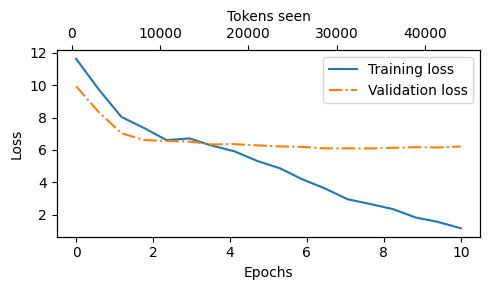

In [18]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)